## Import Libraries

In [110]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory, load_img, img_to_array
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Input
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import random

In [3]:
os.chdir("/kaggle/input/indian-food-classification/Food Classification")  # Feel free to change the file path, I have used kaggle for implementing the notebook

## Import Dataset

In [6]:
dataset = image_dataset_from_directory(
    directory = os.getcwd(),
    color_mode = "rgb",
    image_size = (224, 224),
    label_mode = 'categorical'
)

Found 6269 files belonging to 20 classes.


In [7]:
food_labels = dataset.class_names
print(food_labels)

['burger', 'butter_naan', 'chai', 'chapati', 'chole_bhature', 'dal_makhani', 'dhokla', 'fried_rice', 'idli', 'jalebi', 'kaathi_rolls', 'kadai_paneer', 'kulfi', 'masala_dosa', 'momos', 'paani_puri', 'pakode', 'pav_bhaji', 'pizza', 'samosa']


In [119]:
i = 0
food_label_dict = {food:(i:=i+1) for food in food_labels}

In [120]:
food_label_dict

{'burger': 1,
 'butter_naan': 2,
 'chai': 3,
 'chapati': 4,
 'chole_bhature': 5,
 'dal_makhani': 6,
 'dhokla': 7,
 'fried_rice': 8,
 'idli': 9,
 'jalebi': 10,
 'kaathi_rolls': 11,
 'kadai_paneer': 12,
 'kulfi': 13,
 'masala_dosa': 14,
 'momos': 15,
 'paani_puri': 16,
 'pakode': 17,
 'pav_bhaji': 18,
 'pizza': 19,
 'samosa': 20}

## Train Test split

In [8]:
train_size = int(dataset.cardinality().numpy() * 0.8)   # 80% of the total data is used for training
train_set = dataset.take(train_size)
test_set = dataset.skip(train_size)

In [124]:
print(f"Number of images in training set (approx.): {train_set.cardinality().numpy() * 32}")
print(f"Number of images in test set (approx.): {test_set.cardinality().numpy() * 32}")

Number of images in training set (approx.): 4992
Number of images in test set (approx.): 1280


## Visualize random images

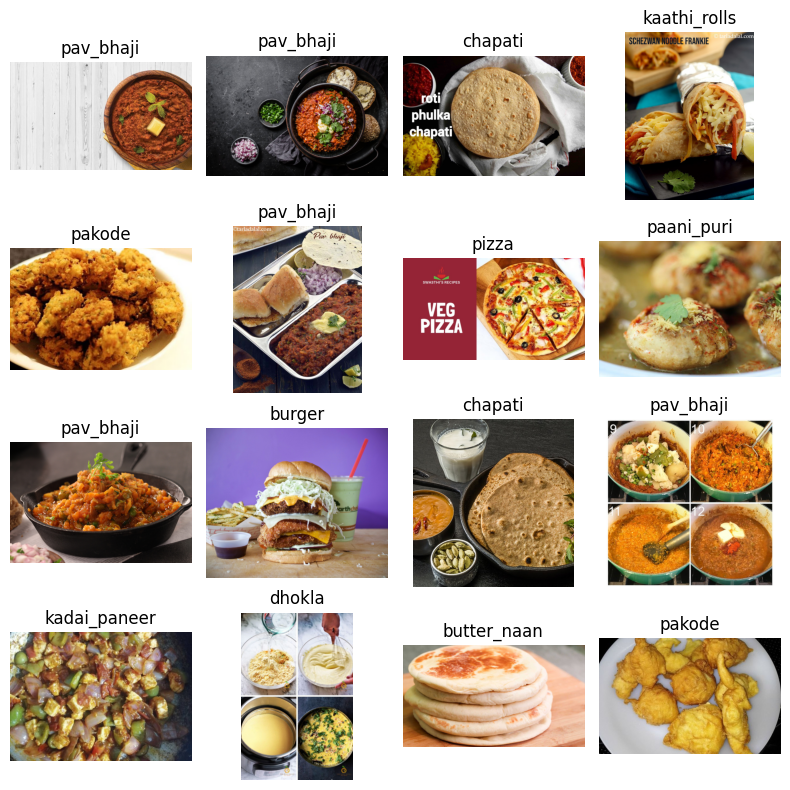

In [10]:
DIR_PATH = os.getcwd()

fig, ax = plt.subplots(nrows = 4, ncols = 4, figsize = (8, 8))

for i in range(4):
    for j in range(4):
        rand_class = random.choice(os.listdir())
        class_path = os.path.join(DIR_PATH, rand_class)
        img_path = os.path.join(class_path, random.choice(os.listdir(class_path)))
        img = mpimg.imread(img_path)
        ax[i][j].imshow(img)
        ax[i][j].axis('off')
        ax[i][j].set_title(rand_class)
        
plt.tight_layout()

## Class Distribution

In [11]:
class_freqs = []
class_names = []

for folder in os.listdir(DIR_PATH):
    class_freqs += [len(os.listdir(os.path.join(DIR_PATH, folder)))]
    class_names.append(folder) 

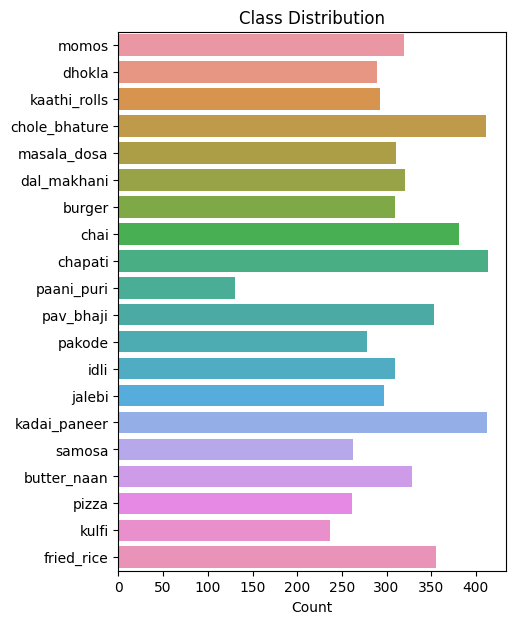

In [12]:
plt.figure(figsize = (5, 7))
sns.barplot(y = pd.Series(class_names), x = pd.Series(class_freqs))
plt.title("Class Distribution")
plt.xlabel("Count");

#### Some Important functions for modelling experiments

In [35]:
def model_ckpt(model_name):
    return ModelCheckpoint(
        filepath = f'/kaggle/working/saved_models/{model_name}',
        monitor = 'val_accuracy',
        save_best_only = True
    )

In [48]:
def plot_model_performance(hist_obj, width = 10, height = 4):
    plt.figure(figsize = (width, height))
    plt.subplot(1, 2, 1)
    plt.plot(np.array(hist_obj.epoch)+1, hist_obj.history["accuracy"], label = "train_acc")
    plt.plot(np.array(hist_obj.epoch)+1, hist_obj.history["val_accuracy"], label = "val_acc")
    plt.title("Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(np.array(hist_obj.epoch)+1, hist_obj.history["loss"], label = "train_loss")
    plt.plot(np.array(hist_obj.epoch)+1, hist_obj.history["val_loss"], label = "val_loss")
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

## Model1: CNN architecture

In [130]:
# Model Architecture

inputs = Input(shape = (224, 224, 3))

x = Conv2D(filters = 64, kernel_size = (3, 3), input_shape = (224, 224, 3), padding = 'valid', strides = (1, 1), activation = 'relu')(inputs)
x = Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', strides = (1, 1), activation = 'relu')(x)
x = MaxPool2D(pool_size = (2, 2), strides = (1, 1))(x)

x = Conv2D(filters = 64, kernel_size = (3, 3), padding = 'valid', strides = (1, 1), activation = 'relu')(x)
x = MaxPool2D(pool_size = (2, 2), strides = (2, 2))(x)

x = Flatten()(x)
x = Dropout(rate = 0.3)(x)
outputs = Dense(units = len(food_labels), activation = 'softmax')(x)

model1 = Model(inputs, outputs)

# Compile
model1.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)


In [131]:
model1.summary()

In [132]:
model1.fit(train_set, validation_data = test_set, epochs = 5, callbacks = [model_ckpt(model_name = "custom_cnn")])

## Model2: ResNetV2

In [50]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input

resnet = ResNet50V2(include_top = False, pooling = 'avg')

94668760/94668760 [==============================] - 1s 0us/step


In [51]:
resnet.trainable = False

In [57]:
inputs = Input(shape = (224, 224, 3))
x = preprocess_input(inputs)
x = resnet(x)
x = Dense(units = 128, activation = 'relu')(x)
x = Dropout(rate = 0.4)(x)
outputs = Dense(units = len(food_labels), activation = 'softmax')(x)

model2 = Model(inputs, outputs)

model2.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.002),
    metrics = ['accuracy']
)

In [58]:
model2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_3 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_3 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense_14 (Dense)            (None, 128)               262272    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0   

In [59]:
resnet_hist = model2.fit(train_set, validation_data = test_set, epochs = 7, callbacks = [model_ckpt(model_name = "resnet")])

Epoch 1/7
156/156 [==============================] - 127s 772ms/step - loss: 1.5216 - accuracy: 0.5583 - val_loss: 0.8807 - val_accuracy: 0.7392
Epoch 2/7
156/156 [==============================] - 123s 776ms/step - loss: 0.9360 - accuracy: 0.7286 - val_loss: 0.7452 - val_accuracy: 0.7823
Epoch 3/7
156/156 [==============================] - 123s 771ms/step - loss: 0.7180 - accuracy: 0.7827 - val_loss: 0.7300 - val_accuracy: 0.7940
Epoch 4/7
156/156 [==============================] - 123s 773ms/step - loss: 0.5956 - accuracy: 0.8149 - val_loss: 0.6899 - val_accuracy: 0.8058
Epoch 5/7
156/156 [==============================] - 104s 648ms/step - loss: 0.5276 - accuracy: 0.8429 - val_loss: 0.6693 - val_accuracy: 0.8019
Epoch 6/7
156/156 [==============================] - 125s 783ms/step - loss: 0.4477 - accuracy: 0.8598 - val_loss: 0.6808 - val_accuracy: 0.8081
Epoch 7/7
156/156 [==============================] - 124s 781ms/step - loss: 0.4047 - accuracy: 0.8726 - val_loss: 0.6471 - val_ac

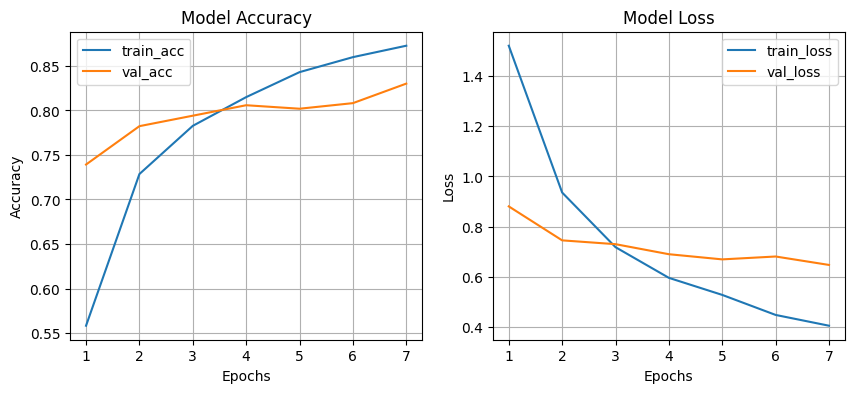

In [60]:
plot_model_performance(resnet_hist)

In [61]:
resnet_best_model = tf.keras.models.load_model("/kaggle/working/saved_models/resnet")

In [86]:
_, accuracy = resnet_best_model.evaluate(test_set)
print(f"Accuracy of ResNet50V2: {accuracy:.2f}")

40/40 [==============================] - 55s 251ms/step - loss: 0.6556 - accuracy: 0.8277
Accuracy of ResNet50V2: 0.83


## Model3: EfficientNetV2B2

In [63]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B2, preprocess_input
effnet_v2_b2 = EfficientNetV2B2(include_top = False, pooling = 'max')

In [64]:
effnet_v2_b2.trainable = False

In [65]:
inputs = Input(shape = (224, 224, 3))
x = preprocess_input(inputs)
x = effnet_v2_b2(x)
x = Dense(units = 128, activation = 'relu')(x)
outputs = Dense(units = len(food_labels), activation = 'softmax')(x)
model3 = Model(inputs, outputs)

model3.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.002),
    metrics = ['accuracy']
)

In [66]:
model3.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b2 (Functio  (None, 1408)              8769374   
 nal)                                                            
                                                                 
 dense_16 (Dense)            (None, 128)               180352    
                                                                 
 dense_17 (Dense)            (None, 20)                2580      
                                                                 
Total params: 8952306 (34.15 MB)
Trainable params: 182932 (714.58 KB)
Non-trainable params: 8769374 (33.45 MB)
_________________________________________________________________


In [67]:
effnet_hist = model3.fit(train_set, validation_data = test_set, callbacks = [model_ckpt("effnet_v2_b2")], epochs = 7)

Epoch 1/7


2023-12-28 16:36:03.057202: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/efficientnetv2-b2/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


156/156 [==============================] - 160s 942ms/step - loss: 2.2117 - accuracy: 0.4537 - val_loss: 1.1001 - val_accuracy: 0.6875
Epoch 2/7
156/156 [==============================] - 145s 913ms/step - loss: 0.9221 - accuracy: 0.7348 - val_loss: 0.7721 - val_accuracy: 0.7737
Epoch 3/7
156/156 [==============================] - 146s 922ms/step - loss: 0.7517 - accuracy: 0.7778 - val_loss: 0.7102 - val_accuracy: 0.7901
Epoch 4/7
156/156 [==============================] - 147s 932ms/step - loss: 0.6503 - accuracy: 0.8071 - val_loss: 0.7301 - val_accuracy: 0.7956
Epoch 5/7
156/156 [==============================] - 146s 924ms/step - loss: 0.5360 - accuracy: 0.8425 - val_loss: 0.6912 - val_accuracy: 0.8019
Epoch 6/7
156/156 [==============================] - 146s 923ms/step - loss: 0.4973 - accuracy: 0.8502 - val_loss: 0.6187 - val_accuracy: 0.8246
Epoch 7/7
156/156 [==============================] - 147s 927ms/step - loss: 0.4335 - accuracy: 0.8734 - val_loss: 0.5438 - val_accuracy: 0.

In [68]:
effnet_best_model = tf.keras.models.load_model("/kaggle/working/saved_models/effnet_v2_b2")

In [85]:
_, accuracy = effnet_best_model.evaluate(test_set)
print(f"Accuracy of EfficientV2B2: {accuracy:.2f}")

40/40 [==============================] - 56s 244ms/step - loss: 0.5691 - accuracy: 0.8442
Accuracy of EfficientV2B2: 0.84


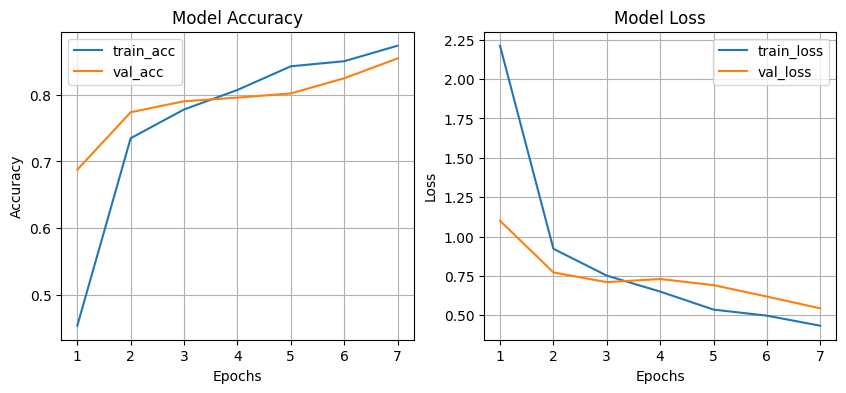

In [70]:
plot_model_performance(effnet_hist)

In [71]:
# !zip -r /kaggle/working/effnet_model.zip /kaggle/working/saved_models/effnet_v2_b2   # Archiving the directory content for download

  adding: kaggle/working/saved_models/effnet_v2_b2/ (stored 0%)
  adding: kaggle/working/saved_models/effnet_v2_b2/keras_metadata.pb (deflated 96%)
  adding: kaggle/working/saved_models/effnet_v2_b2/variables/ (stored 0%)
  adding: kaggle/working/saved_models/effnet_v2_b2/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: kaggle/working/saved_models/effnet_v2_b2/variables/variables.index (deflated 75%)
  adding: kaggle/working/saved_models/effnet_v2_b2/saved_model.pb (deflated 91%)
  adding: kaggle/working/saved_models/effnet_v2_b2/assets/ (stored 0%)
  adding: kaggle/working/saved_models/effnet_v2_b2/fingerprint.pb (stored 0%)


## Predicting random images

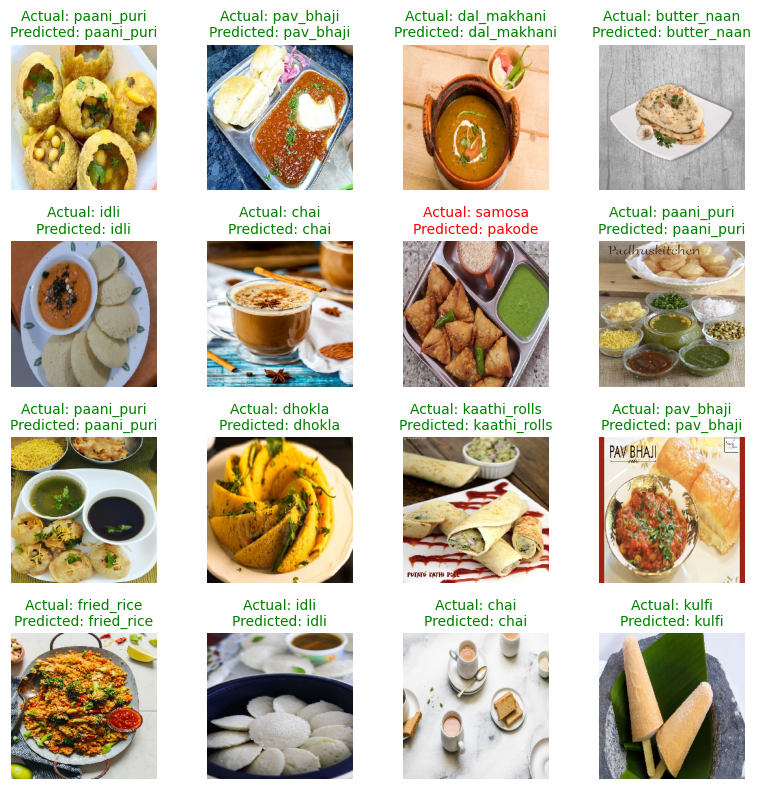

In [152]:
DIR_PATH = os.getcwd()

fig, ax = plt.subplots(nrows = 4, ncols = 4, figsize = (8, 8))

for i in range(4):
    for j in range(4):
        rand_class = random.choice(os.listdir())
        class_path = os.path.join(DIR_PATH, rand_class)
        img_path = os.path.join(class_path, random.choice(os.listdir(class_path)))
        img = load_img(img_path, target_size = (224, 224))
        img = img_to_array(img)
        ax[i][j].imshow(img/255.)
        ax[i][j].axis('off')
        img = np.expand_dims(img, axis = 0)
        pred_ind = np.squeeze(np.argmax(effnet_best_model.predict(img, verbose = 0), axis = 1))
        if(food_labels[int(pred_ind)] == rand_class):
            ax[i][j].set_title(f"Actual: {rand_class}\nPredicted: {food_labels[pred_ind]}", color = 'green', fontsize = 10)
        else:
            ax[i][j].set_title(f"Actual: {rand_class}\nPredicted: {food_labels[pred_ind]}", color = 'red', fontsize = 10)
        
plt.tight_layout()

## Loading the images in the array format for model evaluation

In [105]:
def images_in_array(dir_path = "/kaggle/input/indian-food-classification/Food Classification"):
    images = []
    labels = []
    for folder in os.listdir(dir_path):
        for file in os.listdir(os.path.join(dir_path, folder)):
            img = load_img(os.path.join(dir_path, folder, file), target_size = (224, 224))
            images.append(img_to_array(img))
            labels.append(folder)
            
    return images, labels

In [106]:
images, labels = images_in_array()   # labels are in string (food name) format

In [109]:
images = np.array(images)
labels = np.array(labels)

images.shape, labels.shape

((6271, 224, 224, 3), (6271,))

In [121]:
label_index = np.array([food_label_dict[food_name]-1 for food_name in labels])  # Converting food names to corresponding indices
label_index.shape

(6271,)

## Evaluating Model performance

In [111]:
y_pred = np.argmax(effnet_best_model.predict(images, verbose = 1), axis = 1)

196/196 [==============================] - 13s 69ms/step


In [127]:
print(f"Accuracy score: {accuracy_score(label_index, y_pred):.2f}")
print(f"Recall score: {recall_score(label_index, y_pred, average = 'macro'):.2f}")
print(f"Precision score: {precision_score(label_index, y_pred, average = 'macro'):.2f}")
print(f"F1 score: {f1_score(label_index, y_pred, average = 'macro'):.2f}")

Accuracy score: 0.91
Recall score: 0.92
Precision score: 0.91
F1 score: 0.91


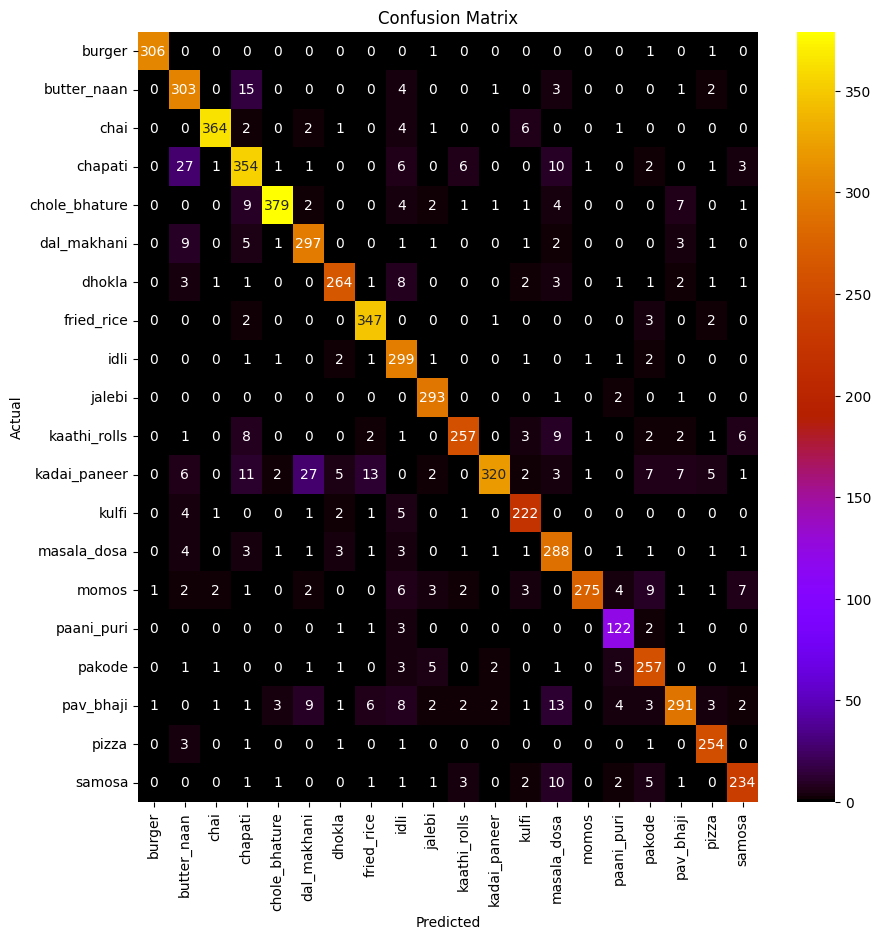

In [151]:
plt.figure(figsize = (10, 10))
sns.heatmap(confusion_matrix(label_index, y_pred), fmt = 'd', annot = True, cmap = 'gnuplot')
plt.xticks(np.arange(20) + .5, food_labels, rotation = 90)
plt.yticks(np.arange(20) + .5, food_labels, rotation = 0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()